# O que está sendo pedido
As equipes devem selecionar um problema de mineração de dados utilizando pelo menos uma das técnicas trabalhadas na disciplina (classificação de textos, agrupamento de dados estruturados ou regressão). Vocês precisam entregar o notebook onde realizaram o trabalho (.ipynb) e um relatório técnico(.pdf).

O notebook precisa conter todos os passos realizados durante a análise, o que foi testado, o que foi observado em cada análise, as decisões tomadas e suas justificativas. O relatório deverá ter um formato mais profissional, sem códigos, apenas com a apresentação do projeto (introdução, apresentação dos dados, objetivo, metodologia, principais insights e resultados observados e a conclusão com verificação do objetivo proposto). Considerem um relatório que será entregue a um gestor numa empresa. A ideia é que seja algo bem objetivo, porém de qualidade. 
Os critérios de avaliação serão: 

* Estrutura e organização do relatório e notebook;
* Análise exploratória: análise univariada e multivariada;
* Pré-processamento: aplicação correta das técnicas de pré-processamento ensinadas em sala que fizerem sentido para a base analisada;
* Mineração: aplicação dos algoritmos de classificação apresentados até o momento no curso e tunning de parâmetros;
* Avaliação: definição de uma metodologia de avaliação que faça sentido para o projeto em questão a fim de verificar a utilidade e confiabilidade dos padrões observados. Aqui eu espero não só análise estatística da performance dos classificadores, mas uma discussão sobre os padrões encontrados e as deficiências (quando ele erra mais?)

Anexem aqui o relatório final, o notebook e as fontes de dados utilizadas. Basta uma postagem por equipe.

# Categoria de Notícias
## Análise do dataset 'News Category Dataset'
###### Este notebook é parte integrante do conjunto de arquivos referentes à avaliação final da disciplina de Data Analytics Hands On.

### Grupo de trabalho

1. João Freitas,
2. João Kruschewsky,
3. Vinícius Matos, 
4. Vito Magarão 

## Link para a base de dados
#### https://www.kaggle.com/datasets/rmisra/news-category-dataset

## Resumo do dataset

Este dataset contém cerca de 210 mil manchetes e breves descrições de notícias entre 2012 a 2022 do HuffPost. Devido a mudanças no site, são cerca de 200 mil manchetes entre 2012 e maio de 2018 e 10 mil manchetes entre maio de 2018 e 2022. Cada notícia contém uma categoria atribuida pela equipe do HuffPost.

## Objetivo do trabalho

Baseado nas informações disponíveis, este trabalho tem o intuito de criar um modelo preditivo que seja capaz de classificar uma nóticia existente na base de treinamento, a partir da manchete e/ou texto descritivo.

## Métricas de análise



# Carregamento da base

### Importando Connectores e Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle # muito bom para algoritmos já treinados, manipular o output dos algoritmos de ML 
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
import emoji
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from pprint import pprint
import numpy as np
import string
import spacy
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
import nltk # principal biblioteca do python para processamento de linguagem natural

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# bibliotecas para esconder os avisos do seaborn
import warnings
warnings.filterwarnings("ignore")
import textwrap 

In [ ]:
!pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached emoji-2.2.0-py3-none-any.whl
  Attempting uninstall: emoji
    Found existing installation: emoji 1.7.0
    Uninstalling emoji-1.7.0:
      Successfully uninstalled emoji-1.7.0


In [ ]:
!pip uninstall emoji
!pip install emoji==1.7

Found existing installation: emoji 2.2.0
Uninstalling emoji-2.2.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/emoji-2.2.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/emoji/*
Proceed (Y/n)? Y
  Successfully uninstalled emoji-2.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached emoji-1.7.0-py3-none-any.whl


In [ ]:
# comment after running
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [ ]:
%matplotlib inline

### Configurando exibição do dataset

In [ ]:
pd.set_option('display.max_columns', None)

### Carregando o Data Frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_json('../content/drive/MyDrive/News_Category_Dataset_v3.json', lines=True)
#df = pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)

In [ ]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

As varíaveis 'link', 'authors' e 'date' não são relevantes para nossa análise e portanto serão dropadas do dataset. 

Faremos também uma reorganização do dataset para melhor visualização.

In [ ]:
df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)
nova_ordem = ['headline','short_description','category']
df = df.reindex(columns = nova_ordem)

### Backup do Data Frame

In [ ]:
df_backup = df.copy()

### Verificando o resultado da importação

In [ ]:
df.head()

,headline,short_description,category
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS


In [ ]:
df.tail()

,headline,short_description,category
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...,TECH
209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",SPORTS
209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...",SPORTS
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,SPORTS
209526,Dwight Howard Rips Teammates After Magic Loss ...,The five-time all-star center tore into his te...,SPORTS


# Funções

In [ ]:
# Função que lista todos os caracteres únicos presentes em todo o dataframe
def get_unique_chars(df): 
    text = ''.join(df['noticia'].astype(str).values.flatten())
    unique_chars = list(set(text))
    return unique_chars


# Limpeza de colunas do dataframe para o primeiro parse 
def cleaning_df (df,column_name):
    df_clean = df.copy()
    exclude_chars = ["’", "—", "–",'™']
    for char in exclude_chars:
        # Essa expressão regular remove todos os caracteres que não estão no alfabeto ou que possuem comprimento menor que 2. Ela também removerá "s" e sinais de pontuação.
        df_clean[column_name] = df_clean[column_name].replace(to_replace=r'[^a-zA-Z]|(\b\w{1}\b)', value=' ', regex=True)
    df_clean[column_name] = df_clean[column_name].replace(regex=r' +', value=' ') # remove quaisquer espaços duplicados ou triplicados que foram gerados como resultado da primeira linha.
    df_clean[column_name] = [content.translate(str.maketrans('','', string.punctuation)) for content in df_clean[column_name]]
    df_clean[column_name] = [content.translate(str.maketrans('','', string.digits)) for content in df_clean[column_name]]
    df_clean[column_name] = df_clean[column_name].str.strip()
    return(df_clean)

# Dicionário de Dados
Coleção de metadados que contém definições, informações e representações de elementos de dados

#### Descrição dos atributos e dos tipos de dados

headline: Manchete da notícia

short_description: Descrição curta da notícia

category: Categoria atribuída pelo HuffPost à notícia

# Análise da variável 'category'


## Valores únicos

In [ ]:
len(df['category'].unique())

42

In [ ]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

É possível perceber de que esse dataset possui um número elevado de categorias e que, em razão disso, poderíamos assumir a estratégia de agrupá-las em novas categorias para aumentar a acertividade do modelo.

Entretanto, em face do tamanho do dataset, optamos por escolher as três categorias com maior número de registros e treinar o modelo para identificá-las

## Balanceamento de 'category'

In [ ]:
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

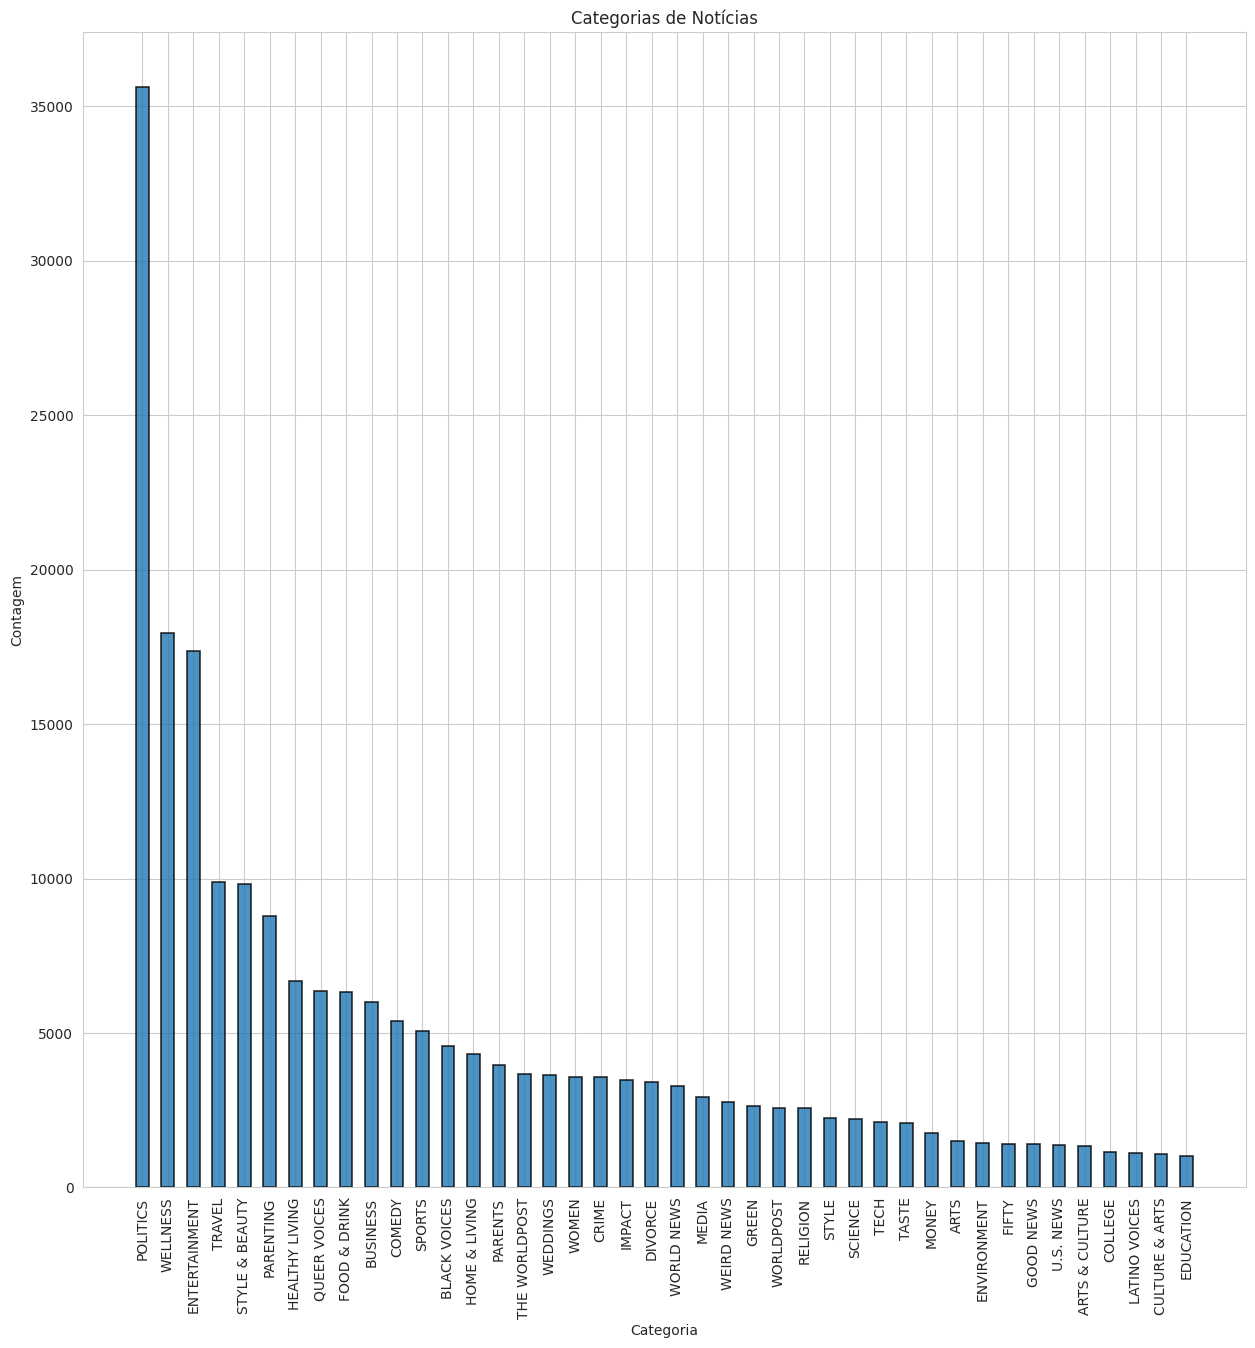

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.bar(df['category'].value_counts().index, 
        height=df['category'].value_counts().values,
        tick_label=df['category'].value_counts().index,
        width=0.5,
        align='center',
        edgecolor='black',
        linewidth=1.2,
        alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.title('Categorias de Notícias')
plt.show()

As categorias 'Politics', 'Wellness' e 'Entertainment' representam 16,3%, 8,9% e 8% do dataset, respectivamente. Considerando o tamanho, podemos considerar que essas variáveis são representativas e que podem ser usadas para uma análise apartada do todo.

## Definindo o dataset da análise

In [ ]:
#df = df.query("category == 'POLITICS' or category == 'ENTERTAINMENT' or category == 'WELLNESS'")

In [ ]:
df = df.query("category == 'BUSINESS' or category == 'COMEDY' or category == 'SPORTS'")

In [ ]:
df['category'].unique()

array(['COMEDY', 'SPORTS', 'BUSINESS'], dtype=object)

# Análise dos atributos do dataset

## Informações preliminares

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16469 entries, 2 to 209526
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   headline           16469 non-null  object
 1   short_description  16469 non-null  object
 2   category           16469 non-null  object
dtypes: object(3)
memory usage: 514.7+ KB


### Verificação de entradas duplicadas

In [ ]:
df.duplicated().sum() #total de duplicatas

12

In [ ]:
df.drop_duplicates(keep='last', inplace=True)

In [ ]:
df.duplicated(subset=['headline','short_description']).sum() #número de duplicatas em 'headline' e 'short_description'

0

In [ ]:
df.drop_duplicates(subset=['headline','short_description'],keep='last',inplace=True)

### Valores nulos ou vazios

In [ ]:
print(len(df[df['headline'] == ""]))

1


In [ ]:
print(len(df[df['short_description'] == ""]))

2271


In [ ]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


In [ ]:
df.loc[df['short_description'] == "", 'short_description'] = np.nan
df.dropna(subset=['short_description'], inplace=True)
print(len(df[df['short_description'] == ""]))

0


É preciso verificar também se existem manchetes ou descrições com menos de X caracteres, pois sua relevância pode ser mínima ou até atrapalhar na construção do modelo.





In [ ]:
for comment in df['short_description']:
    if len(comment) <= 10:
        print(comment)

Ouch!
Ewww!
Ouch.
Aha!
Nailed it.
Who knew?
Eww.
Almost.
Ouch!
Sniff.
Catchy!
Exposed!
Ouch!
Pantastic!
Ouch!
Awww!
Nailed it!
"Oh no."
Oops.
Wahoo!
Go Pats.
WOW!
Uh-oh.
Ewww!
EWWWW!
#FakeWolf!
Eww.
Oops!
😂
😱😱😱
Ewww.
OUCH!
🔥🔥🔥
Burrrrrn 🔥
It's on.
Awww.
Ugh.
👻  😂
Ouch.
Ohhhhhhh!
😱  😂
"Sad!"
Awkward!
Zing.
All Rise!
💩💩💩
So bitter.
BURNED!
Ruthless.
Huh!
Sleeeeep!
Got milk?
😂😂😂😂😂
Uncanny.
Happy 4th!
Kind of.
Whoops!!!
D’oh!
🐶🐶🐶
🐶🐶🐶
"Kill me."
TV magic!
Nailed it.
WHOA!
"Fierce."
🙅🙅🙅
Of course.
Too funny.
It's ugly.
😂😂😂
And more!
Phew ...
*Sort of.
Oh, ew.
"Be Mein!"
REAL NEWS.
🙄
Fine art.
Yep.
Burn.
Epic!
Baller.
Re2pect.
Yikes!
"Superb."
Shazam!
D'oh!
Dope.
Just wow.
SPOILERS!
Fierce!
Like wow!
Déjà vu.
Woooo!
Legend.
Too good.
AMERICA!
Literally.
Ew.
WOW!
Yikes.
We know!
Go Simone!
Ouch.
Aaaargh!!!
Yes!!
😢
Hint: 💸💸💸
Inspiring.
Brilliant!
Burn.
Perfect.
Awww!
WHOA!
So classy.
Yikes.
No. Words.
Oof.
Fail!
🍕
Wow.
It's on.
Overcome.
Oof.
R.I.P.
Watch out!
HMMM.
Yee-haw!
"Damn it!"
Well done

In [ ]:
#df = df[df['short_description'].str.len() > 3]

# Reagrupamento

## Função de agrupamento

In [ ]:
categorias = df['category'].value_counts().index

def agrupador(grouplist,name):
    for ele in categorias:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

## Formação das novas categorias

In [ ]:
print("Agora, nós temos um total de {} categorias".format(df['category'].nunique()))
df['category'].value_counts()

Agora, nós temos um total de 3 categorias


BUSINESS    5130
COMEDY      4642
SPORTS      4414
Name: category, dtype: int64

# Uniformização dos dados

## Aplicando padrões e correções

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14186 entries, 2 to 209526
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   headline           14186 non-null  object
 1   short_description  14186 non-null  object
 2   category           14186 non-null  object
dtypes: object(3)
memory usage: 443.3+ KB


In [ ]:
df.describe()

,headline,short_description,category
count,14186,14186,14186
unique,14136,14130,3
top,The Best Late Night Clips of the Week (VIDEO/P...,Ouch.,BUSINESS
freq,26,5,5130


In [ ]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

Considerando que a manchete e o texto descritivo se complementam, podemos unir as variáveis 'headline' e 'short_description' em uma nova variável chamada 'noticia', afim de possibilitar o processo de lematização.

In [ ]:
df['noticia'] = df['headline'].astype(str)+"-"+df['short_description']
df.drop(columns = ['headline','short_description'],axis = 1, inplace=True)
df['noticia'] = df['noticia'].astype(str)
df['category'] = df['category'].astype('category')
df.head()

,category,noticia
0,COMEDY,"Huckabee, Trump And Cruz Are The Three Amigos ..."
1,COMEDY,Howard Schultz Reveals The Starbucks Barista R...
2,BUSINESS,The 14 Principles of a Future Organization-We ...
3,COMEDY,Nick Offerman Is Back With Another Marvelous E...
4,COMEDY,Top 17 People Jeremy Lin SHOULD NOT Be Compare...


In [ ]:

#```!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# FICO ME PERGUNTANDO SE EXCLUIR AS DESCRIÇÕES QUE SÃO SÓ EMOJI AJUDA OU NÃO
#```!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# FUNÇÃO PARA EXCLUIR EMOJI CASO NECESSÁRIO
# import emoji

#def has_emoji(text):
#    for character in text:
#        if character in emoji.UNICODE_EMOJI:
#            return True
#    return False
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
        u"\U0001F680-\U0001F6FF"  # transporte e mapas
        u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           "]+", flags=re.UNICODE)
# extraindo as linhas que não contêm emojis
df['noticia'] = df['noticia'].apply(lambda x: emoji_pattern.sub(r'', x))

In [ ]:
unique_chars = get_unique_chars(df)
unique_chars.sort(reverse = True)
print(unique_chars)

['🤔', '🤑', '️', 'ﬁ', 'ツ', '❤', '⚾', '♬', '─', '™', '€', '›', '‹', '\u2028', '…', '”', '“', '’', '‘', '―', '—', '–', '\u200b', '\u200a', 'č', 'ć', 'ü', 'ø', 'ó', 'ñ', 'ï', 'í', 'ë', 'é', 'ç', 'ä', 'â', 'á', 'à', '¯', '®', '\xad', '©', '£', '¡', '\xa0', '~', '|', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', '^', ']', '\\', '[', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '@', '?', '>', '=', ';', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', ',', '+', '*', ')', '(', "'", '&', '%', '$', '#', '"', '!', ' ', '\n']


# Verificando a distribuição do comprimento de cada comentário

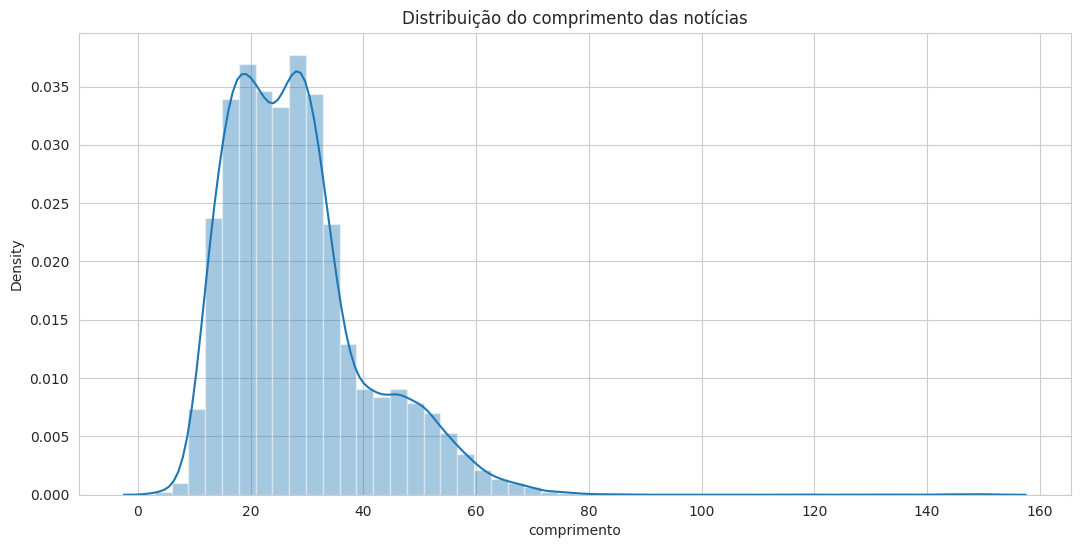

In [ ]:
df['comprimento'] =  [len(sentence.split()) for sentence in df['noticia']]
plt.figure(figsize=(12.8,6))
sns.distplot(df['comprimento']).set_title('Distribuição do comprimento das notícias');

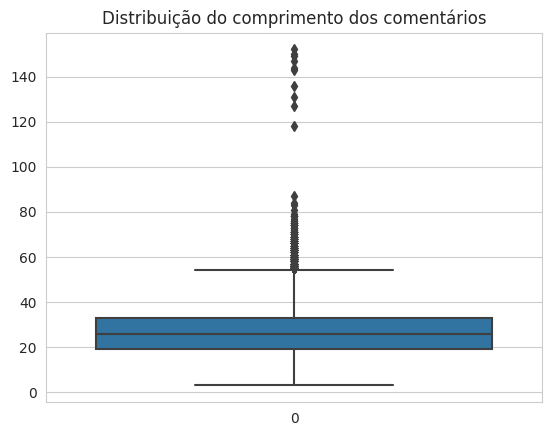

In [ ]:
sns.boxplot(df['comprimento']).set_title('Distribuição do comprimento dos comentários');

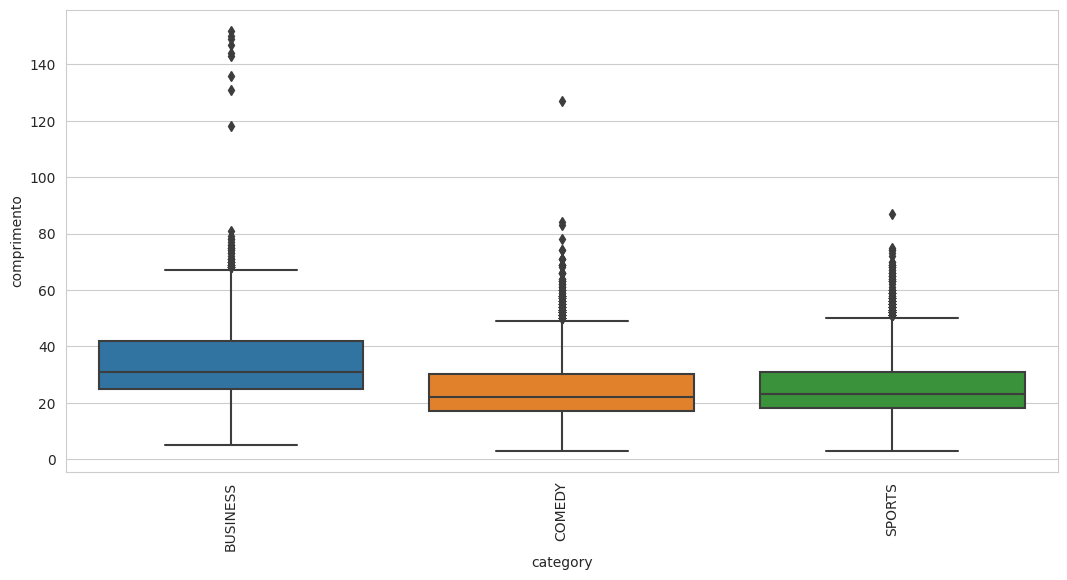

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='category', y='comprimento', width=.8)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.groupby('category').describe()

comprimento                                                    
               count       mean        std  min   25%   50%   75%    max
category                                                                
BUSINESS      5130.0  34.009162  13.271543  5.0  25.0  31.0  42.0  152.0
COMEDY        4642.0  24.096726  10.316679  3.0  17.0  22.0  30.0  127.0
SPORTS        4414.0  25.242184  10.576238  3.0  18.0  23.0  31.0   87.0

#Remoção de caracteres especiais e números

É possível identificar que no dataframe temos alguns caracteres que interferem e/ou não contribuem para os resultados finais, removeu-se tudo que era numérico, tudo que era pontuação e adicionalmente sinais gráficos como  [" ’ ", "—", "–",'™']

In [ ]:
df_clean = cleaning_df(df,'noticia')
unique_chars = get_unique_chars(df_clean)

unique_chars.sort(reverse = True)

In [ ]:
# adicionando a nova coluna como Parse_1 no df original
df['parse_1'] = df_clean['noticia']

# Lematização e stematização

In [ ]:
# baixando as listas de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))
stop_words.append('trump')
stop_words.append('donald')
nlp = spacy.load("en_core_web_sm")
wnl = WordNetLemmatizer()
# porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer(language="english")


In [ ]:
df_backup = df.copy()

Separando 10% do dataset para análise de modelos devido ao alto custo computacional. Separamos 10% de cada categoria para manter as proporções do dataset original.

In [ ]:
category_counts = df_backup['category'].value_counts()

# Define the fraction of rows to be randomly selected
frac = 0.75

# Create an empty dataframe to store the sampled rows
random_cut_df = pd.DataFrame()

# For each category, sample a fraction of rows and add them to the new dataframe
for category, count in category_counts.items():
    group = df_backup[df_backup['category'] == category]
    sample = group.sample(frac=frac, random_state=42) # Set random_state for reproducibility
    random_cut_df = random_cut_df.append(sample)


df = random_cut_df

In [ ]:
df.size

42560

In [ ]:
df = df.reset_index()

In [ ]:
import multiprocessing as mp

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [w.lemma_ for w in doc if w.lemma_ not in stop_words]
    return " ".join(lemmas)

def stem_text(text):
    words = text.lower().split()
    stems = [lancaster.stem(w) for w in words if w not in stop_words]
    return " ".join(stems)

def snowball_text(text):
    words = text.lower().split()
    stems = [snowball.stem(w) for w in words if w not in stop_words]
    return " ".join(stems)

pool = mp.Pool(processes=3)

df['parse_2a'] = pool.map(lemmatize_text, df['parse_1'])
df['parse_2b'] = pool.map(stem_text, df['parse_1'])
df['parse_2c'] = pool.map(snowball_text, df['parse_1'])

pool.close()
pool.join()

## Evolução após cada iteração

In [ ]:
df.loc[15]['noticia']

'Sandwich Chain Jimmy John’s Plans October IPO-The deal will value the company around $2 billion, people who have seen the deal documents say.'

In [ ]:
df.loc[15]['parse_1']

'Sandwich Chain Jimmy John Plans October IPO The deal will value the company around billion people who have seen the deal documents say'

In [ ]:
df.loc[15]['parse_2a']


'sandwich Chain Jimmy John Plans October IPO deal value company around billion people see deal document say'

In [ ]:
df.loc[15]['parse_2b']

'sandwich chain jimmy john plan octob ipo deal valu company around bil peopl seen deal docu say'

In [ ]:
df.loc[15]['parse_2c']

'sandwich chain jimmi john plan octob ipo deal valu compani around billion peopl seen deal document say'

In [ ]:
#Base tratada
df['Content_Parsed'] = df['parse_2b']

# Separação entre Treino e Teste

## Data Modeling

### Divisão do Treino e Teste

In [ ]:
df['category'] = df['category'].replace('BUSINESS', 0)
df['category'] = df['category'].replace('COMEDY', 1)
df['category'] = df['category'].replace('SPORTS', 2)

In [ ]:
train_df, test_df, train_target, test_target = train_test_split(df['Content_Parsed'], 
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=1)

###Reanálise

In [ ]:
class preProcess():
    
    def __init__(self,train_df, test_df, train_target, test_target,ngram_range = (1,2),min_df = 0.01,max_df = 0.99,max_features = None, stop_words = list(stopwords.words('english'))):

        self.tfidf = TfidfVectorizer(encoding='utf-8',
                                ngram_range=ngram_range,
                                stop_words=stop_words,
                                lowercase=True,
                                max_df=max_df,
                                min_df=min_df,
                                max_features=max_features,
                                sublinear_tf=True)
                                
        self.features_train = self.tfidf.fit_transform(train_df).toarray()
        self.labels_train = train_target
        print(self.features_train.shape)

        self.features_test = self.tfidf.transform(test_df).toarray()
        self.labels_test = test_target
        print(self.features_test.shape)

In [ ]:
preProcessor = preProcess(train_df, test_df, train_target, test_target)

(8512, 312)
(2128, 312)


Apesar de conservador, utilizar 2% como mínimo e 98% como máximo, o impacto nas features existentes é bem relevante. Passamos de (237, 4082) x (27, 4082) para (237, 206) x (27, 206)

## Identificação das Categorias


In [ ]:
category_codes = {
'BUSINESS': 0,
'COMEDY': 1,
'SPORTS': 2,
}

In [ ]:
df.head()

,index,category,noticia,comprimento,parse_1,parse_2a,parse_2b,parse_2c,Content_Parsed
0,14118,0,"No Winner In $500 Million Powerball Lottery, O...",17,No Winner In Million Powerball Lottery Officia...,Winner million Powerball Lottery official say ...,win mil powerbal lottery off say estim priz sa...,winner million powerbal lotteri offici say est...,win mil powerbal lottery off say estim priz sa...
1,6039,0,Social Media Guidelines for Your Employees-Whi...,36,Social Media Guidelines for Your Employees Whi...,Social Media Guidelines employee social medium...,soc med guidelin employ soc med platform cre n...,social media guidelin employe social media pla...,soc med guidelin employ soc med platform cre n...
2,12101,0,Can you Turn Your Website into a Business-Buil...,51,Can you Turn Your Website into Business Buildi...,turn website Business Building App every compa...,turn websit busy build ap every company websit...,turn websit busi build app everi compani websi...,turn websit busy build ap every company websit...
3,2280,0,"Women in Business Q&A: Jeni Garrett, CEO and F...",55,Women in Business Jeni Garrett CEO and Founder...,woman Business Jeni Garrett CEO Founder Woodho...,wom busy jen garret ceo found woodh day spa je...,women busi jeni garrett ceo founder woodhous d...,wom busy jen garret ceo found woodh day spa je...
4,3904,0,The Leadership Paradox-I suggest we need to st...,71,The Leadership Paradox suggest we need to step...,Leadership Paradox suggest need step back cons...,lead paradox suggest nee step back consid lead...,leadership paradox suggest need step back cons...,lead paradox suggest nee step back consid lead...


## Correlação de Palavras com Categorias


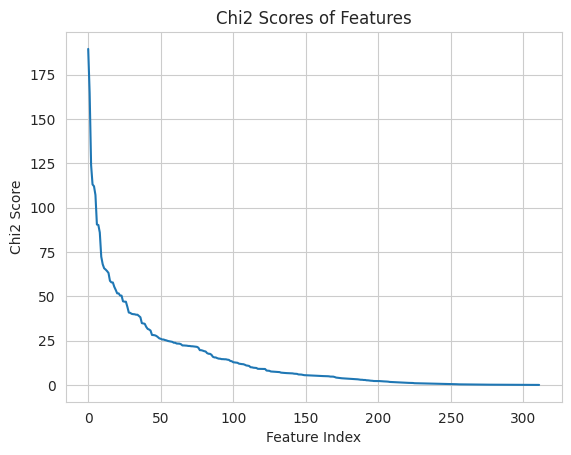

# Classe 'BUSINESS' :

 » Unigramas mais correlacionados:
. company
. busy
. econom
. market
. work

 » Bigramas mais correlacionados:
. wal st
. steph colbert
. bil mah

 » Principais correlações:
. company
. busy
. econom
. market
. work
. ceo
. job
. employ
. bank
. invest
. corp
. play
. olymp
. wal st
. video
. success
. gam
. custom
. wal
. sal
----------------------------------------------------------------------------------------------------------------------------



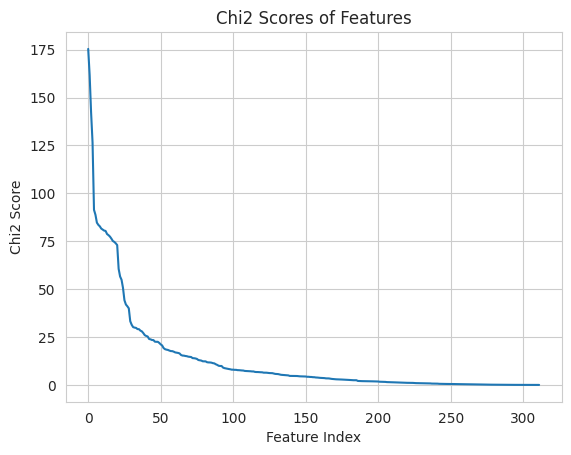

# Classe 'COMEDY' :

 » Unigramas mais correlacionados:
. colbert
. snl
. jimmy
. fallon
. mah

 » Bigramas mais correlacionados:
. steph colbert
. bil mah
. jimmy fallon

 » Principais correlações:
. colbert
. snl
. steph colbert
. jimmy
. fallon
. mah
. bil mah
. jimmy fallon
. seth
. kimmel
. hil
. show
. steph
. mey
. seth mey
. jimmy kimmel
. trev noah
. video
. noah
. trev
----------------------------------------------------------------------------------------------------------------------------



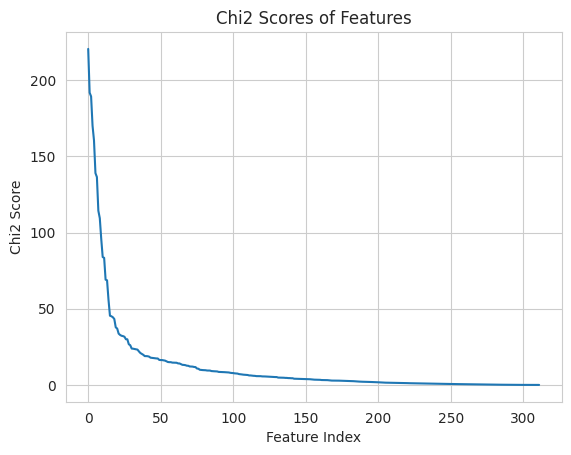

# Classe 'SPORTS' :

 » Unigramas mais correlacionados:
. olymp
. nfl
. play
. gam
. team

 » Bigramas mais correlacionados:
. sup bowl
. steph colbert
. bil mah

 » Principais correlações:
. olymp
. nfl
. play
. gam
. team
. footbal
. nba
. sport
. athlet
. champ
. win
. fan
. leagu
. coach
. bowl
. company
. busy
. sup bowl
. gold
. work
----------------------------------------------------------------------------------------------------------------------------



In [ ]:
def get_feature_names(preProcessor,category_id:int):
    features_chi2 = chi2(preProcessor.features_train, preProcessor.labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(preProcessor.tfidf.get_feature_names_out())[indices]

    sorted_indices = np.argsort(features_chi2[0])[::-1]

    # Sort the chi2 scores
    sorted_chi2 = features_chi2[0][sorted_indices]

    # Create the line plot
    plt.plot(sorted_chi2)
    plt.xlabel('Feature Index')
    plt.ylabel('Chi2 Score')
    plt.title('Chi2 Scores of Features')
    plt.show()
    return feature_names

def print_important_feature(product):
   
    unigrams = [word for word in feature_names if len(word.split(' ')) == 1]
    bigrams = [word for word in feature_names if len(word.split(' ')) == 2]
    
    print("# Classe '{}' :".format(product))
    print("")
    print(" » Unigramas mais correlacionados:\n. {}".format('\n. '.join(unigrams[-5:][::-1])))
    print("")
    print(" » Bigramas mais correlacionados:\n. {}".format('\n. '.join(bigrams[-3:][::-1])))
    print("")
    print(" » Principais correlações:\n. {}".format('\n. '.join(feature_names[-20:][::-1])))
    print("----------------------------------------------------------------------------------------------------------------------------")
    print("")

for product, category_id in sorted(category_codes.items()):

    feature_names = get_feature_names(preProcessor, category_id)

    print_important_feature(product)

asdasdasdasd

# Seleção de Atributos


Definiremos o k inicialmente como 100 para visualizar a efetividade do código e, posteriormente, modificá-lo se necessário.

In [ ]:
selector = SelectKBest(chi2, k=200)

features_train = selector.fit_transform(preProcessor.features_train, preProcessor.labels_train)
features_test = selector.transform(preProcessor.features_test)

print(features_train.shape)
print(features_test.shape)

# Criação do Modelo

In [ ]:
def display_results(preProcessor,rfc_pred):
    acc = accuracy_score(preProcessor.labels_test, rfc_pred)
    f1 = f1_score(preProcessor.labels_test, rfc_pred, average='macro')
    print(classification_report(preProcessor.labels_test,rfc_pred, digits=4))

    aux_df = preProcessor.labels_train.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(preProcessor.labels_test, rfc_pred)
    fig, ax = plt.subplots(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues",
                fmt='d',
                ax=ax)
    ax.set_ylabel('Real')
    ax.set_xlabel('Previsto')
    ax.set_title('Matriz de confusão')
    plt.show()
    return np.round(f1, 4), np.round(acc, 4)

def display_results(preProcessor,rfc_pred):
    acc = accuracy_score(preProcessor.labels_test, rfc_pred)
    f1 = f1_score(preProcessor.labels_test, rfc_pred, average='macro')
    print(classification_report(preProcessor.labels_test,rfc_pred))

    aux_df = preProcessor.labels_train.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(preProcessor.labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [ ]:
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}

## 1. Random Forest

#### Cross Validation do Random Search

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1200, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(15, 80, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10, # número de combinações 
                                   scoring=score_metrics, # metodo de avaliação
                                   refit='F1', # método utilizado para refitagem
                                   cv=10, # número de folds
                                   verbose=1, 
                                   random_state=8, 
                                   n_jobs =-1) # processamento paralelo

random_search.fit(features_train, preProcessor.labels_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: ignored

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Random Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Random Search são:
{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}

A macro F1 obtida com esses hiperparâmetros é:
0.705812704138756


#### 1.2. Treinamento e avaliação do modelo

              precision    recall  f1-score   support

           0     0.8216    0.8258    0.8237       792
           1     0.7242    0.7815    0.7518       682
           2     0.8188    0.7462    0.7808       654

    accuracy                         0.7871      2128
   macro avg     0.7882    0.7845    0.7854      2128
weighted avg     0.7895    0.7871    0.7875      2128



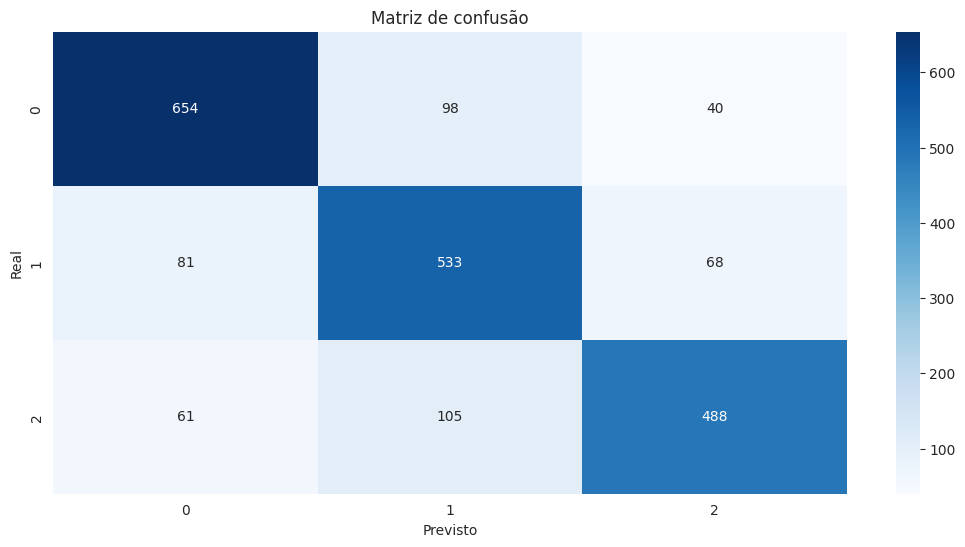

In [ ]:
#results = random_search.cv_results_
#best_rfc = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

best_rfc.fit(features_train, preProcessor.labels_train)
rfc_pred = best_rfc.predict(features_test)


f1,acc = display_results(preProcessor,rfc_pred)

Dada Matriz de confusão, podemos notar alguns pontos referentes à cada classe:

Classe 0 - obteve uma boa performace

Classe 1,2 - houve bastante confusão na hora de diferenciar classes 1 e 2 para o modelo, porém para estimar a classe 1 obtiveram-se bons resultados.


In [ ]:
y_pred = random_search.predict(features_test)

# Create a DataFrame with the predicted and actual labels
results_df = pd.DataFrame({'Actual': preProcessor.labels_test, 'Predicted': y_pred})

# Add the features to the DataFrame
results_df = pd.concat([results_df, pd.DataFrame(features_test)], axis=1)

# Filter the DataFrame to include only instances where the prediction was incorrect
errors_df = results_df[results_df['Actual'] != results_df['Predicted']]

In [ ]:
resumo_erro = errors_df.iloc[:, :2]

In [ ]:
resumo_erro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296 entries, 9486 to 2127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Actual     600 non-null    category
 1   Predicted  600 non-null    float64 
dtypes: category(1), float64(1)
memory usage: 38.2 KB


In [ ]:
resumo_erro["Mesclar"] = resumo_erro["Actual"].astype(str) + resumo_erro["Predicted"].astype(str)

In [ ]:

indices = resumo_erro.index.tolist()


In [ ]:
df.iloc[indices][]

,index,category,noticia,comprimento,parse_1,parse_2a,parse_2b,parse_2c,Content_Parsed
9486,10190,2,How Tim Wakefield's Retirement Brought Me a Li...,39,How Tim Wakefield Retirement Brought Me Little...,Tim Wakefield Retirement bring I Little close ...,tim wakefield retir brought littl clos dea dem...,tim wakefield retir brought littl closer death...,tim wakefield retir brought littl clos dea dem...
9799,3131,2,"It's Official, Donald Sterling Will Never Own ...",11,It Official Donald Sterling Will Never Own The...,official Donald Sterling never clipper thank g...,off sterl nev clip thank good,offici sterl never clipper thank good,off sterl nev clip thank good
2397,3906,0,'Carpool Karaoke' Will Now Play On 'Apple Musi...,20,Carpool Karaoke Will Now Play On Apple Music F...,Carpool Karaoke play Apple Music First late La...,carpool karaok play appl mus first lat lat sho...,carpool karaok play appl music first late late...,carpool karaok play appl mus first lat lat sho...
2072,4956,0,Stand With Striking Walmart Workers on Black F...,29,Stand With Striking Walmart Workers on Black F...,stand Striking Walmart Workers Black Friday vi...,stand striking walmart work black friday video...,stand strike walmart worker black friday video...,stand striking walmart work black friday video...
619,10867,0,Libor Investigation Close To Making Arrests: R...,24,Libor Investigation Close To Making Arrests Re...,Libor Investigation close make Arrests Report ...,lib investig clos mak arrest report barclay se...,libor investig close make arrest report barcla...,lib investig clos mak arrest report barclay se...
...,...,...,...,...,...,...,...,...,...
2122,12174,0,Bank Of America Facing $864 Million Fine After...,33,Bank Of America Facing Million Fine After Mort...,Bank America Facing Million Fine Mortgage Frau...,bank americ fac mil fin mortg fraud verdict ne...,bank america face million fine mortgag fraud v...,bank americ fac mil fin mortg fraud verdict ne...
2124,7705,0,How The Financial Crisis Is Killing African Ch...,30,How The Financial Crisis Is Killing African Ch...,Financial Crisis kill African Children Gold ge...,fin cris kil afr childr gold gen gre pr slick ...,financi crisi kill african children gold gener...,fin cris kil afr childr gold gen gre pr slick ...
2125,5704,0,A Comeuppance For Bank Of America?-Susan Richa...,24,Comeuppance For Bank Of America Susan Richards...,comeuppance Bank America Susan Richardson Bank...,comeup bank americ sus richardson bank americ ...,comeupp bank america susan richardson bank ame...,comeup bank americ sus richardson bank americ ...
2126,1797,0,The Company Christmas Party-Some dos and don't...,23,The Company Christmas Party Some dos and don t...,Company Christmas Party ts Click AUDIO version...,company christmas party dos ts click audio ver...,compani christma parti dos ts click audio vers...,company christmas party dos ts click audio ver...


In [ ]:
resumo_erro.head(10)
resumo_erro.reset_index()
df3 = resumo_erro.loc[resumo_erro['Mesclar'] == 20.0]

In [ ]:
print(train_target.value_counts(),'\n', test_target.value_counts())

0    3056
1    2800
2    2656
Name: category, dtype: int64 
 0    792
1    682
2    654
Name: category, dtype: int64


- Verificamos que há um pequeno desbalanceamento na base de treino, que inicialmente possuiu mais exemplos da classe 2 e menos exemplos da classe 1. Isso pode justificar a dificuldade do modelo em primeira instancia em diferenciar 1 de 2

In [ ]:
df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
d = {
     'Estimator': 'Random Forest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.706, 0.707)","(0.716, 0.718)"


#### Cross Validation do Grid Search

Como GRID SEARCH realiza todas as combinações lineares dos parâmetro, em aplicações que realmente desejamos variar os parâmetros ela não se faz muito útil (muito tempo de processamento), já que o número de modelos criados é igual à combinação linear de todas as possibilidades. Apenas realizado para fins de demonstração.

In [ ]:
bootstrap = [False]
max_depth = [20,25, 30]
max_features = ['auto','sqrt']
min_samples_leaf = [4]
min_samples_split = [5, 10, 15]
n_estimators = [1200]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 10, test_size = None, random_state = 8)
# testando com fold 10 e test 0 pois ja temos um teste separado

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=2, n_jobs =-1)

# Fit the grid search to the data
grid_search.fit(features_train, preProcessor.labels_train)

print("Os melhores hiperparâmetros encontrados com o Random Search são:")
print(grid_search.best_params_)
print("")
print("A acurácia média obtida com esses hiperparâmetros é:")
print(grid_search.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


KeyboardInterrupt: ignored

## 2. SVM

In [ ]:

C = [.0001, .001, .01]


gamma = [.0001, .001, .01, .1, 1, 10, 100]


degree = [1, 2, 3, 4, 5]


kernel = ['linear', 'rbf', 'poly']


probability = [True]


random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

svc = svm.SVC(random_state=8)


random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=10, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =-1)


random_search.fit(features_train, preProcessor.labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: ignored

In [ ]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 

best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_svm.fit(features_train, preProcessor.labels_train)
svm_pred = best_svm.predict(features_test)

f1,acc = display_results(preProcessor,svm_pred)

In [ ]:
d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

df_estimators_scores

## 3. Multinomial Naïve Bayes


              precision    recall  f1-score   support

           0     0.6484    0.8384    0.7313       792
           1     0.7023    0.6158    0.6563       682
           2     0.8083    0.6254    0.7052       654

    accuracy                         0.7016      2128
   macro avg     0.7197    0.6932    0.6976      2128
weighted avg     0.7148    0.7016    0.6992      2128



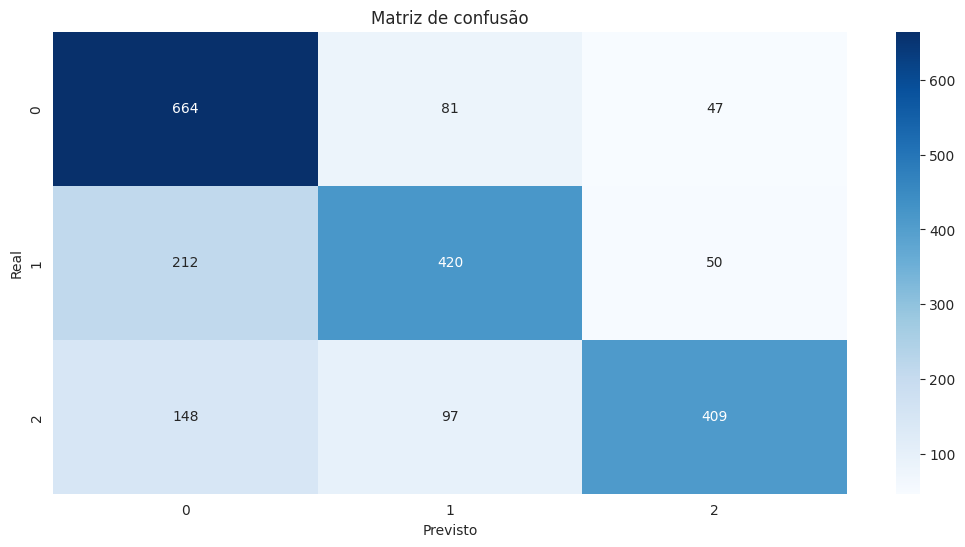

In [ ]:
mnbc = MultinomialNB(alpha=0.433,force_alpha=False,fit_prior=True)
mnbc.fit(features_train, preProcessor.labels_train)
mnbc_pred = mnbc.predict(features_test)
f1,acc = display_results(preProcessor, mnbc_pred)



In [ ]:


scores = cross_validate(mnbc, features_train, preProcessor.labels_train, scoring=score_metrics, cv=10, return_train_score=True)
print(scores.keys())
print(scores['test_F1'])

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

In [ ]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)
df_estimators_scores

# Análise do modelo


Vamos escolher o modelo gerado com o algoritmo Naive Bayes por ter alcançado os melhores indicadores.

In [ ]:
predictions = best_rfc.predict(features_test)

In [ ]:
# Indexes of the test set
index_X_test = test_df.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions

df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['Content_Parsed', 'category', 'Prediction']]

# Decode
df_test['classe_Predicted'] = df_test['Prediction']

# Clean columns again
df_test = df_test[['Content_Parsed', 'category', 'classe_Predicted']]

In [ ]:
condition = (df_test['category'] != df_test['classe_Predicted'])

df_misclassified = df_test[condition]

df_misclassified

,Content_Parsed,category,classe_Predicted
9486,tim wakefield retir brought littl clos dea dem...,2,0
9799,off sterl nev clip thank good,2,1
2397,carpool karaok play appl mus first lat lat sho...,0,2
2072,stand striking walmart work black friday video...,0,1
619,lib investig clos mak arrest report barclay se...,0,2
...,...,...,...
2751,facebook profit soar stock hit tim high facebo...,0,1
1145,comcast talk buy dreamwork anim bil comcast co...,0,1
8589,devon stil acceiv jimmy persev award behalf da...,2,1
8056,cristiano ronaldo snap famy photo bring at syr...,2,1


In [ ]:
df_misclassified.classe_Predicted.value_counts()

1    287
0    207
2    106
Name: classe_Predicted, dtype: int64

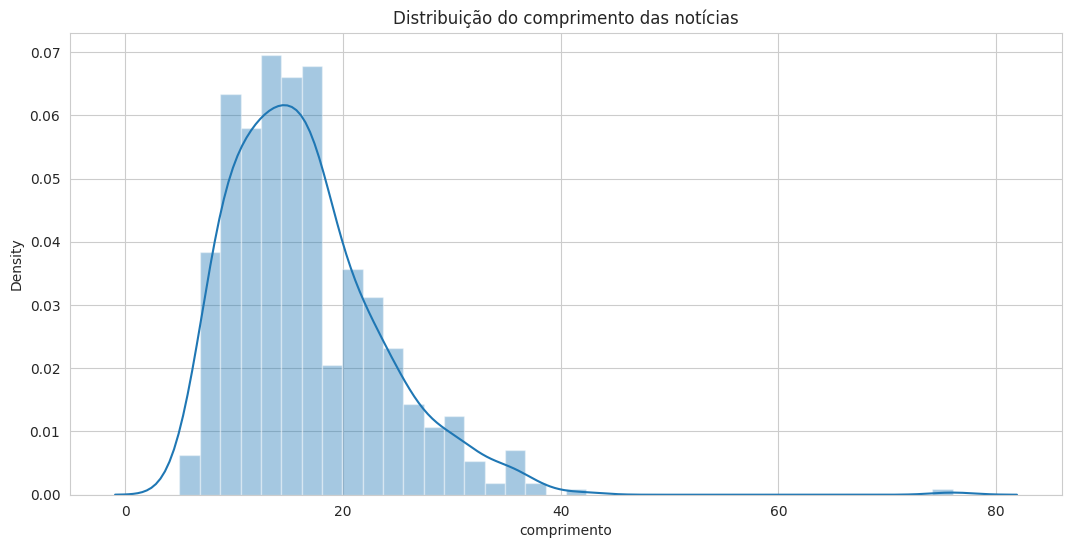

In [ ]:
df_misclassified['comprimento'] =  [len(sentence.split()) for sentence in df_misclassified['Content_Parsed']]
plt.figure(figsize=(12.8,6))
sns.distplot(df_misclassified['comprimento']).set_title('Distribuição do comprimento das notícias');

Densidade parece com a original porém possui um leve desvio para direita.

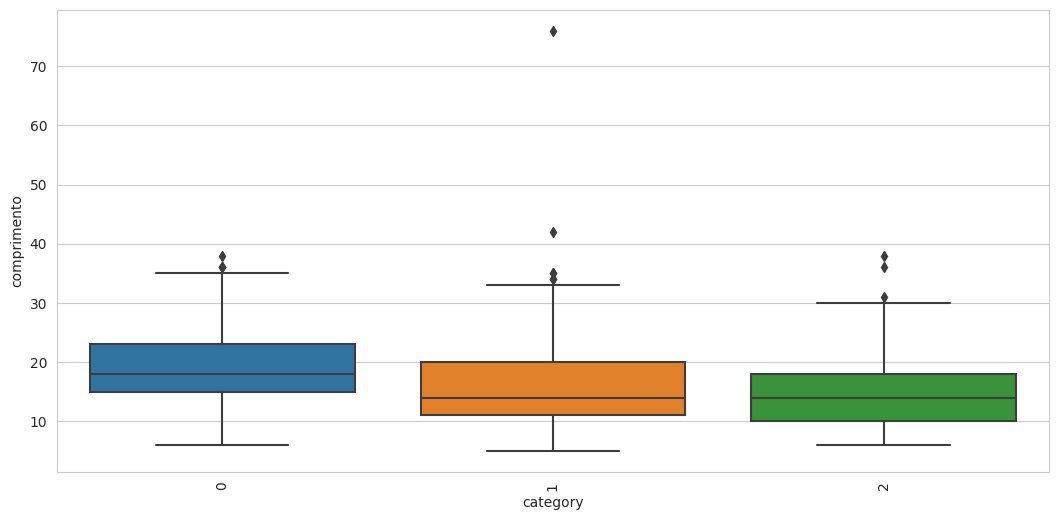

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_misclassified, x='category', y='comprimento', width=.8)
plt.xticks(rotation=90)
plt.show()

Distribuiçāo original

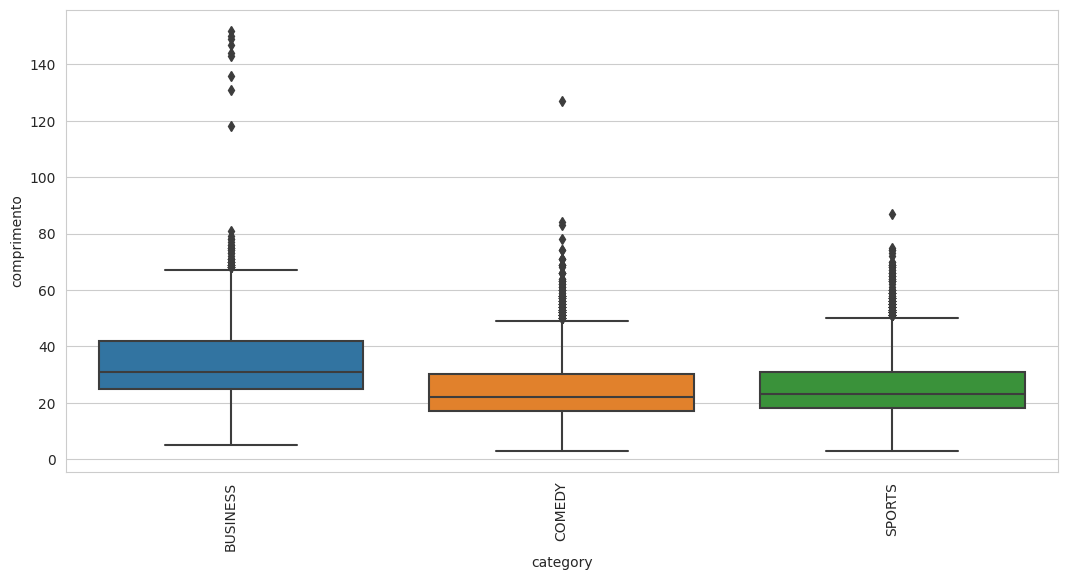

Podemos ver que a distribuiçāo parece semelhante, porém a mediana é menor que a original, isso pode indicar que o modelo possui dificuldade com texto menor. Podemos atacar isso aumentanto o numero de freatures considerados.



In [ ]:
df_misclassified.groupby('category')["comprimento"].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
0,185.0,18.772973,6.617855,6.0,15.0,18.0,23.0,38.0
1,175.0,16.434286,8.585940,5.0,11.0,14.0,20.0,76.0
2,240.0,15.008333,5.660545,6.0,10.0,14.0,18.0,38.0


| category | count | mean | std | min | 25% | 50% | 75% | max |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| BUSINESS | 5130 | 34.009162 | 13.271543 | 5.0 | 25.0 | 31.0 | 42.0 | 152.0 |
| COMEDY | 4642 | 24.096726 | 10.316679 | 3.0 | 17.0 | 22.0 | 30.0 | 127.0 |
| SPORTS | 4414 | 25.242184 | 10.576238 | 3.0 | 18.0 | 23.0 | 31.0 | 87.0 |

In [ ]:
train_df_misclassified, test_df_misclassified, train_target_df_misclassified, test_target_df_misclassified = train_test_split(df_misclassified['Content_Parsed'], 
                                                    df_misclassified['category'], 
                                                    test_size=0.0001, 
                                                    random_state=1)

preProcessor_miss = preProcess(train_df_misclassified, test_df_misclassified, train_target_df_misclassified, test_target_df_misclassified)

(599, 108)
(1, 108)


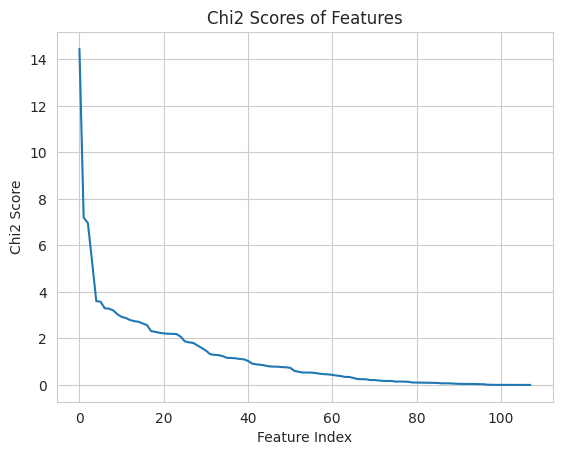

# Classe 'BUSINESS' :

 » Unigramas mais correlacionados:
. bank
. un
. produc
. plan
. maj

 » Bigramas mais correlacionados:
. year old
. sup bowl
. new york

 » Principais correlações:
. bank
. un
. produc
. plan
. maj
. fil
. champ
. keep
. year old
. sup
. publ
. video
. nba
. leagu
. bowl
. year
. sup bowl
. best
. thing
. cut
----------------------------------------------------------------------------------------------------------------------------



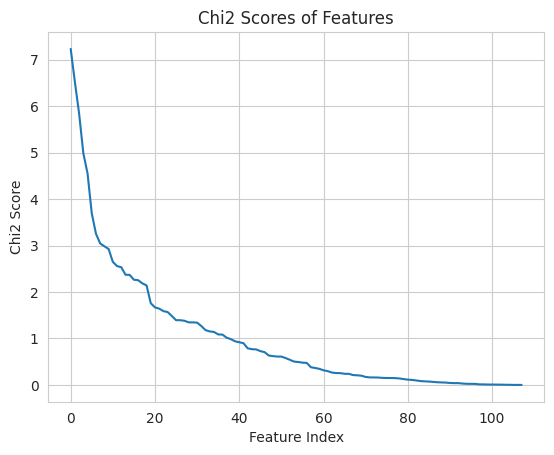

# Classe 'COMEDY' :

 » Unigramas mais correlacionados:
. gam
. thing
. act
. win
. play

 » Bigramas mais correlacionados:
. year old
. sup bowl
. new york

 » Principais correlações:
. gam
. thing
. act
. win
. play
. com
. fan
. champ
. right
. peopl
. every
. work
. leagu
. would
. may
. med
. new
. maj
. first
. look
----------------------------------------------------------------------------------------------------------------------------



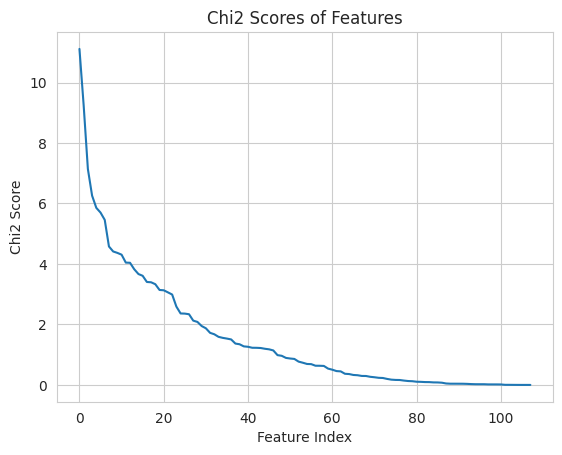

# Classe 'SPORTS' :

 » Unigramas mais correlacionados:
. champ
. leagu
. nba
. back
. bank

 » Bigramas mais correlacionados:
. year old
. sup bowl
. new york

 » Principais correlações:
. champ
. leagu
. nba
. year old
. back
. bank
. play
. gam
. win
. jam
. look
. produc
. bowl
. plan
. video
. sup bowl
. fan
. lif
. un
. act
----------------------------------------------------------------------------------------------------------------------------



In [ ]:
for product, category_id in sorted(category_codes.items()):

    feature_names = get_feature_names(preProcessor_miss, category_id)

    print_important_feature(product)

Realizando analise com mais features:

Foi realizado analise com 200 e 300 features, cortando 0.01 do minimo de features e 0.99 do maximo. Conforme o esperado pela nossa analise aumentar o numero de features melhorou a performance. O melhor resultado foi com 200 features.

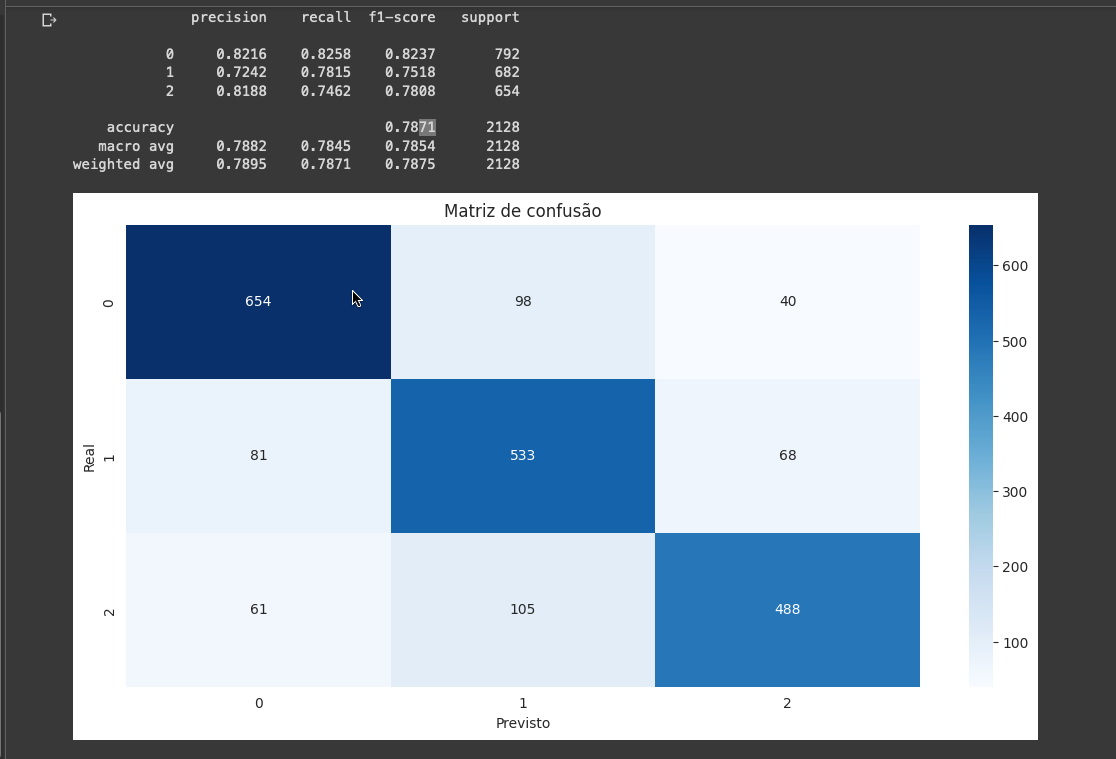
